In [79]:
import hublib
import pandas as pd
import ipywidgets as widgets
from IPython.display import clear_output
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import scipy
from scipy.signal import savgol_filter
import numpy as np
from decimal import Decimal
import unicodedata
from unicodedata import lookup as GL
import sympy as sy
from joblib import Parallel, delayed
from lmfit import Model
import warnings
import zipfile
from zipfile import ZipFile
import os
# from hublib.ui import FileUpload, Download

from scipy import sparse
from scipy.sparse.linalg import spsolve

In [85]:
### Import spectrum and do preliminary calculation here
### Output: I_raw(+ve), W


# import the file. We usually allow users to upload their own file
path = "./data/raw-fit/testing2.txt"
data = pd.read_table(path)

# calculate the number of rows and columns in the file. 
# We use this to determine the format of the file and import the data accordingly
cols = data.shape[1]
rows = data.shape[0]

# import data as a DataFrame, such that the first column has the frequency and the second column has the intensity
if cols == 1:
    data = pd.Dataframe(data.iloc[0:row/2, 0], data.iloc[rows/2:rows, 0])
elif cols == 2:
    if type(data.iloc[0,0]) is str:
        data = data.iloc[1:rows, :]
    else: 
        data = data
else: 
    data = []
    
# create the frequency and intensity numpy arrays
frequency = np.array(data.iloc[:,0])
intensity = np.array(data.iloc[:,1])
length = len(frequency)

# remove all negative values from the two arrays
a = 0
for i in range(length):
    if frequency[i]<=0:
        a = a + 1
    else:
        break
frequency = frequency[a:]
intensity = intensity[a:]

# normalise the intenisty
intensity_norm = []
for i in intensity:
    intensity_norm.append((i-np.min(intensity))/(np.max(intensity)-np.min(intensity)))

In [86]:
### Fit BL
### Input: I_raw, W, *args (degree, here)
### Output: I, W

# define the baseline subtraction function
def fit_BL(degree, x, y):
#     n = degree
#     I_raw = np.array(y)
#     W = np.array(x)
    
#     # perform baseline fitting
#     polyx = np.array([W[0],W[int(len(W)/2)],W[len(W)-1]])
#     polyy = np.array([I_raw[0],I_raw[int(len(W)/2)],I_raw[len(W)-1]])        
#     bkgfit = np.polyfit(W,I_raw,degree)
#     bkgpoly = 0
#     for i in range(n):
#         bkgpoly = bkgpoly + (bkgfit[i]*W**(n-i))
#     I_raw = I_raw-bkgpoly
    
#     # Flatten the baseline
#     m = (I_raw[len(W)-1]-I_raw[0])/(W[len(W)-1]-W[0])
#     b = I_raw[len(W)-1]-m*W[len(W)-1]
#     bkglin = m*W+b
#     I_raw = I_raw-bkglin
    
#     # re-normalise the baseline subracted spectrum
#     I_BL = []
#     I_BL = ((I_raw-np.min(I_raw))/np.max(I_raw-np.min(I_raw)))
    
#     return I_BL

    lam = 100000
    p = 0.01
    niter=10

#     def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
#     return z
        
    I_raw = y-z
    
    print(type(I_raw))
    print(sparse.issparse(I_raw))
    
    # re-normalise the baseline subracted spectrum
    I_BL = []
    I_BL = ((I_raw-np.min(I_raw))/np.max(I_raw-np.min(I_raw)))
    
    print(type(I_BL))
    print(sparse.issparse(I_BL))

    
    return I_BL

In [90]:
y = intensity_norm
window_length = 7
polyorder = 2

y_smooth = savgol_filter(y, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)

In [91]:
### define parameters here. 
### Degree (so far, degree of baseline polynomial)

degree = 3

# call the baseline subtraction function
I_BL = fit_BL(degree, frequency, y_smooth)

<class 'numpy.ndarray'>
False
<class 'numpy.ndarray'>
False


<IPython.core.display.Javascript object>


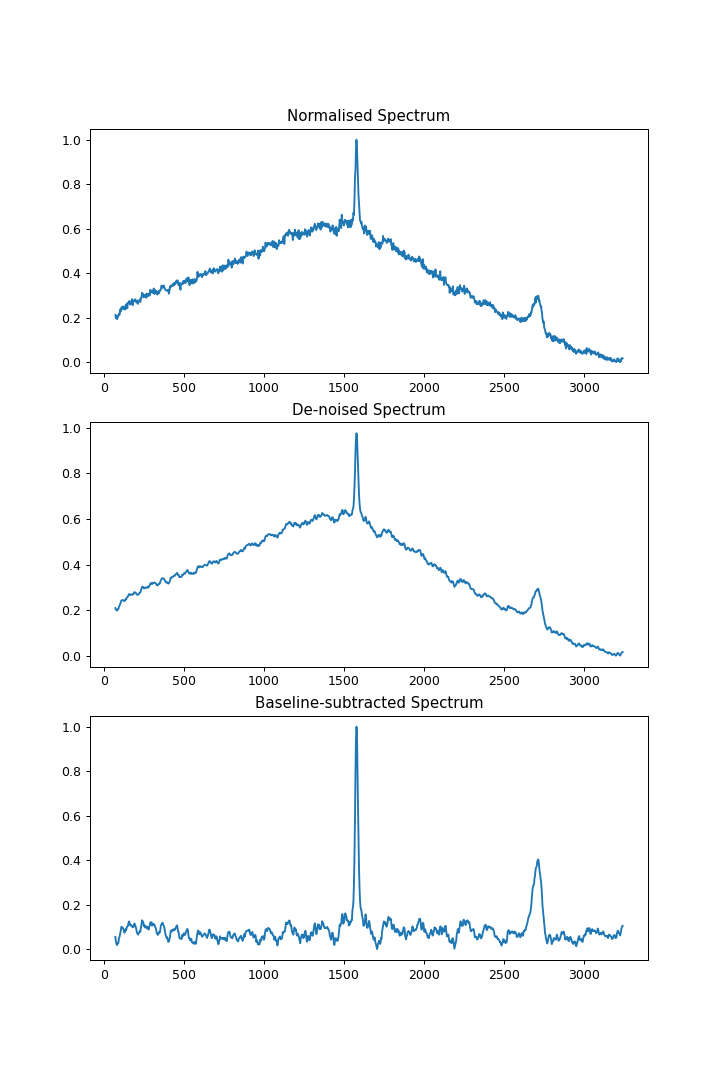

Text(0.5, 1.0, 'Baseline-subtracted Spectrum')

In [92]:
### Plot [I_raw vs W] & [I vs W]

fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(8,12)) # create a figure with sub-plots
ax[0].plot(frequency, intensity_norm); # display the output image
ax[1].plot(frequency, y_smooth) # display the original image
ax[2].plot(frequency, I_BL) # display the original image

# label the images
ax[0].set_title('Normalised Spectrum')
ax[1].set_title('De-noised Spectrum')
ax[2].set_title('Baseline-subtracted Spectrum')

Other residual code: 

In [35]:
def Spectra(s,data):
    srow=0;
    if type(data[0][0])==str:
        srow=1
    
    W=data[0][srow:len(data)]
    W=np.array(W);W=W.astype(float)
    I_raw=data[1][srow:len(data)]
    I_raw=np.array(I_raw);I_raw=I_raw.astype(float)
    I_raw.shape=(100,)
    I_raw.shape[0]=100
    range(100)
    range(1,(I_raw.shape[0]-1))
    
    x = I_raw
    window_length = 15
    polyorder = 3

    I_raw = scipy.signal.savgol_filter(x, window_length, polyorder, deriv=1, delta=1.0, axis=- 1, mode='interp', cval=0.0)

#background fitting could be done, but it sometimes messes up some spectra
#in general, the hope is that the specra will not need it
    
#     polyx=np.array([W[0],W[int(len(W)/2)],W[len(W)-1]])
#     polyy=np.array([I_raw[0],I_raw[int(len(W)/2)],I_raw[len(W)-1]])        
#     bkgfit=np.polyfit(polyx,polyy,2)
#     bkgpoly=(bkgfit[0]*W**2)+(bkgfit[1]*W)+bkgfit[2]
#     I_raw=I_raw-bkgpoly
    
#     m=(I_raw[len(W)-1]-I_raw[0])/(W[len(W)-1]-W[0])
#     b=I_raw[len(W)-1]-m*W[len(W)-1]
#     bkglin=m*W+b

    n=2

    polyx = np.array([W[0],W[int(len(W)/2)],W[len(W)-1]])
    polyy = np.array([I_raw[0],I_raw[int(len(W)/2)],I_raw[len(W)-1]])        
    bkgfit = np.polyfit(W,I_raw,n)
    bkgpoly = 0
    for i in range(n):
        bkgpoly = bkgpoly + (bkgfit[i]*W**(n-i))
    I_raw = I_raw-bkgpoly
    
    m = (I_raw[len(W)-1]-I_raw[0])/(W[len(W)-1]-W[0])
    b = I_raw[len(W)-1]-m*W[len(W)-1]
    bkglin = m*W+b
    
    I_raw=I_raw-bkglin
    
    I=((I_raw-np.min(I_raw))/np.max(I_raw-np.min(I_raw)));
    
    
    s.I=I
    
    s.W=W
    return s